In [3]:
import hopsworks
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/Users/hugolindgren/miniconda3/envs/scalable_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#ML imports
#import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from sklearn.metrics import mean_squared_error


In [5]:
import datetime
year = datetime.date.today().year
year

2023

In [6]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [7]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

valuation_fg = fs.get_feature_group(name="valuationdataset", version=year-2022)
query = valuation_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="valuationdataset_fv",
                                  version=year-2022,
                                  description="Read from valuation dataset",
                                  labels=["market_value_in_eur"],
                                  query=query)

In [113]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

#Drop date column, keeping it because might make sense later

X_train = X_train.drop(columns=["player_id", "date"])
X_test = X_test.drop(columns=["player_id", "date"])

Finished: Reading data from Hopsworks, using ArrowFlight (1.19s) 


In [118]:
y_train.mean()["market_value_in_eur"]

10301209.120221097

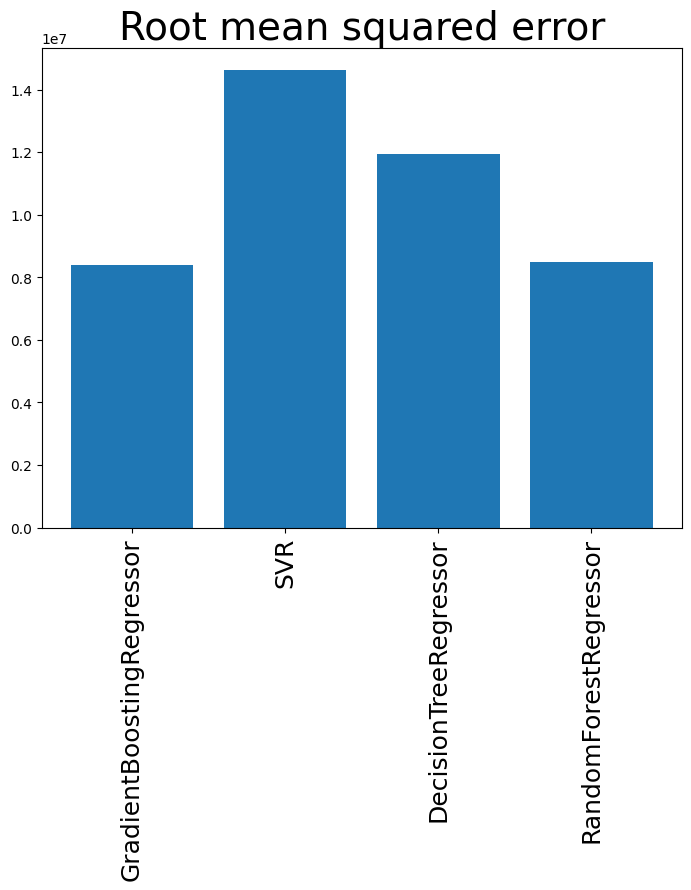

                       model          RSME
0  GradientBoostingRegressor  8.379426e+06
1                        SVR  1.461537e+07
2      DecisionTreeRegressor  1.193883e+07
3      RandomForestRegressor  8.476542e+06


In [114]:
comparisons_df = pd.DataFrame(columns=['model','RSME'])
#model data
gbr = GradientBoostingRegressor(random_state=0)
svr = SVR(kernel="linear",gamma="auto")
dtr = DecisionTreeRegressor(random_state=0)
rfr = RandomForestRegressor(random_state=1)
#cat= CatBoostRegressor(iterations=10,learning_rate=1,depth=3)
#lgbm=LGBMRegressor()

models=[gbr,svr,dtr,rfr]
for model in models:
    model.fit(X_train, y_train)
    #assess accurancy of model
    #comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__,model.score(X_test, y_test)]
    mse = mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse)  # Calculate the RMSE
    comparisons_df.loc[len(comparisons_df)] = [model.__class__.__name__, rmse]
    
#create barchart to show performances
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = comparisons_df.model
y = comparisons_df.RSME
ax.bar(x,y)
plt.xticks(fontsize=18, rotation=90)
plt.title('Root mean squared error',fontsize=28)
plt.show()
print(comparisons_df)




In [94]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



# Initialize a GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)

# Initialize GridSearchCV with reduced verbosity
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and RMSE score
print("Best parameters found: ", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_rmse}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/hugolindgren/miniconda3/envs/scalable_project/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hugolindgren/miniconda3/envs/scalable_project/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hugolindgren/miniconda3/envs/scalable_project/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hugolindgren/miniconda3/envs/scalable_project/lib/python3.10/site-packages/sklearn/ensemble/_

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 8510013.307315078


# First grid search results:
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best RMSE: 8395713.532848323

# With normalization for 'age', 'height_in_cm', 'minutes_played':  
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 8510013.307315078

# With normalization for 'age', 'height_in_cm', 'minutes_played', 'months_left':  
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 8734931.10464566

In [ ]:
new_param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2,3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3]
}

# Assuming GridSearchCV and other necessary imports are already done

# Initialize a new GridSearchCV with the refined parameter grid
new_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0), 
                               param_grid=new_param_grid, 
                               cv=5, n_jobs=-1, verbose=1, 
                               scoring='neg_mean_squared_error')

# Fit the new GridSearchCV
new_grid_search.fit(X_train, y_train)

# Print the best parameters and RMSE score from the new grid search
print("Further optimized parameters: ", new_grid_search.best_params_)
new_best_rmse = np.sqrt(-new_grid_search.best_score_)
print(f"Further optimized RMSE: {new_best_rmse}")


# Test without normalization:

Further optimized parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 90}
Further optimized RMSE: 8382218.227179526

# With normalization for 'age', 'height_in_cm', 'minutes_played': 
Further optimized parameters:  {'learning_rate': 0.15, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 100}
Further optimized RMSE: 8402103.026075723

# With normalization for 'age', 'height_in_cm', 'minutes_played', 'months_left': 

Further optimized parameters:  {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 110}
Further optimized RMSE: 8713902.522456704



Now final test with normalzied columns for age and height

In [107]:
from sklearn.preprocessing import StandardScaler

# Assuming X is your features DataFrame
scaler = StandardScaler()

In [12]:
X_train[['age', 'height_in_cm']] = scaler.fit_transform(X_train[['age', 'height_in_cm']])
X_test[['age', 'height_in_cm']] = scaler.fit_transform(X_test[['age', 'height_in_cm']])

In [13]:

# Initialize a GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.15, max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=100, random_state=42)
# Fit the new GridSearchCV
gbr.fit(X_train, y_train)

mse = mean_squared_error(y_test, gbr.predict(X_test))
rmse = np.sqrt(mse)  # Calculate the RMSE

print(rmse)


7898815.74030217


RMSE: 7898815.74030217

Since the model was significantly better, we continue with normalizing all columns

In [87]:
X_test

,yellow_cards,red_cards,goals,assists,minutes_played,height_in_cm,age,months_left,own_goals,opponent_goals,clean_sheets,league_es1,league_fr1,league_gb1,league_it1,league_l1,position_attack,position_defender,position_goalkeeper,position_midfield
1,2,0,0,0,-1.257642,-0.887120,-1.381401,-0.232923,52,56,10,False,False,False,True,False,False,False,False,True
4,1,0,0,0,-1.222922,0.582427,-1.592281,1.137485,53,57,11,True,False,False,False,False,False,False,False,True
7,0,0,0,0,-0.873113,0.729382,-0.748761,1.137485,45,52,10,False,False,True,False,False,False,True,False,False
11,2,0,0,0,0.757014,0.582427,0.516520,-0.918127,107,67,24,False,False,True,False,False,False,True,False,False
18,2,0,0,3,0.625944,-0.152346,-0.748761,1.137485,80,54,25,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,6,0,1,2,0.270059,0.435473,1.570921,-0.918127,36,68,6,False,False,False,True,False,False,False,False,True
2682,0,0,3,0,1.085990,1.611111,0.727401,1.137485,64,52,13,False,False,True,False,False,False,True,False,False
2691,7,0,2,7,1.147619,-2.062758,-0.116120,1.822689,49,67,4,True,False,False,False,False,False,False,False,True
2699,0,0,0,0,-1.320139,-2.209713,-0.959641,-0.232923,40,65,10,True,False,False,False,False,True,False,False,False


In [84]:
X_train[['age', 'height_in_cm', 'minutes_played', 'months_left']] = scaler.fit_transform(X_train[['age', 'height_in_cm', 'minutes_played', 'months_left']])

X_test[['age', 'height_in_cm', 'minutes_played', 'months_left']] = scaler.fit_transform(X_test[['age', 'height_in_cm', 'minutes_played', 'months_left']])




Normalizing these parameters gave us the following result for RSME: 7530008.385672017

In [108]:
X_train[['age', 'height_in_cm', 'minutes_played']] = scaler.fit_transform(X_train[['age', 'height_in_cm', 'minutes_played']])

X_test[['age', 'height_in_cm', 'minutes_played']] = scaler.fit_transform(X_test[['age', 'height_in_cm', 'minutes_played']])

RME after normalization of the following params: 6574252.793060527

In [111]:
# Initialize a GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.15, max_depth=4, min_samples_leaf=2, min_samples_split=8, n_estimators=100)
# Fit the new GridSearchCV
gbr.fit(X_train, y_train)

mse = mean_squared_error(y_test, gbr.predict(X_test))
rmse = np.sqrt(mse)  # Calculate the RMSE

print(rmse)


8570391.39140741
